In [2]:
import pandas as pd
import scipy
from scipy import stats

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

   * LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
   * SEX: пол клиента (1 = мужской, 2 = женский )
   * EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
   * MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
   * AGE: возраст в годах
   * PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
   * BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
   * PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
   * default - индикатор невозврата денежных средств

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv', sep = ',', header = 0)

In [5]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
print len(data) - len(data.dropna())

0


## Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [7]:
good = data[data.default == 0]
bad = data[data.default == 1]

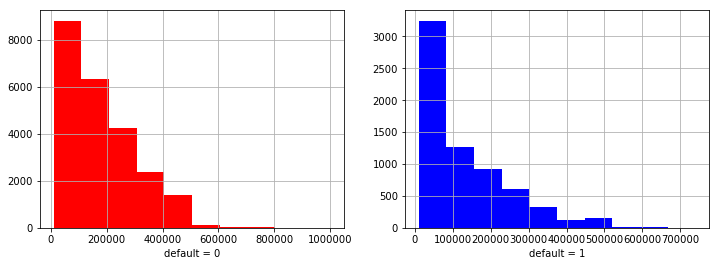

In [10]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(good.LIMIT_BAL.values, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(bad.LIMIT_BAL.values, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

### a) интервальную оценку проводим с помощью бутстрапа

### Интервальная оценка медиан

In [11]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [12]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [13]:
np.random.seed(0)

good_limit_median_scores = map(np.median, get_bootstrap_samples(good.LIMIT_BAL.values , 1000))
bad_limit_median_scores = map(np.median, get_bootstrap_samples(bad.LIMIT_BAL.values , 1000))

print "95% confidence interval for the non-default median limit bal:", stat_intervals(good_limit_median_scores , 0.05)
print "95% confidence interval for the default median limit bal:", stat_intervals(bad_limit_median_scores , 0.05)

95% confidence interval for the non-default median limit bal: [ 150000.  150000.]
95% confidence interval for the default median limit bal: [ 80000.  90000.]


### Точечная оценка разности медиан

In [14]:
print "difference between medians:", np.median(good.LIMIT_BAL.values) - np.median(bad.LIMIT_BAL.values)

difference between medians: 60000.0


### Интервальная оценка разности медиан

In [15]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(bad_limit_median_scores, good_limit_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 60000.  70000.]


Вывод: гипотеза о равенстве мединных значений кредитного лимита уверенно отвергается, причем различие 60 - 70 тыс. практически значимо.

### b) проверяем при помощи критериев для независимых выборок

### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [16]:
stats.mannwhitneyu(bad.LIMIT_BAL.values, good.LIMIT_BAL.values)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [18]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [19]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [20]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

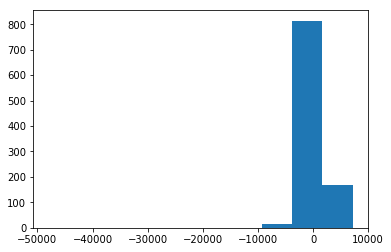

In [55]:
pylab.hist(permutation_zero_dist_ind(bad.LIMIT_BAL.values, good.LIMIT_BAL.values, max_combinations = 1000))
pylab.show()

In [21]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [22]:
print "p-value: %f" % permutation_test(bad.LIMIT_BAL.values, good.LIMIT_BAL.values, max_permutations = 5000)

p-value: 0.000200


Вывод: обоими критериями гипотеза о равестве распределений отвергается

## Задание 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия) 

In [23]:
non_default_sex_dist = data[data.default == 0].SEX.values
non_default_sex_dist[:] -= 1
default_sex_dist = data[data.default == 1].SEX.values
default_sex_dist[:] -= 1

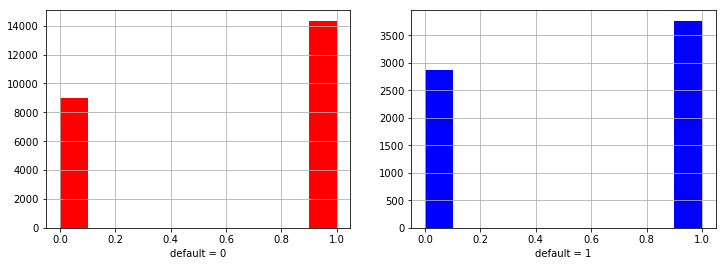

In [24]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(non_default_sex_dist, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(default_sex_dist, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

## Z-критерий для разности долей (независимые выборки)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [25]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [28]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(non_default_sex_dist, default_sex_dist)

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


In [29]:
print "two-sided p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(non_default_sex_dist, default_sex_dist))

two-sided p-value: 0.000000


In [30]:
proportions_diff_z_test(proportions_diff_z_stat_ind(non_default_sex_dist, default_sex_dist))

4.4728665216098307e-12

Вывод: 0 не попадает в доверительный интервал, а p-value очень маленькое, то есть оба метода указывают на то, что гендерный состав отличается

## Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

H0: признаки EDUCATION и default независимы

H1: H0 неверна

In [31]:
non_default_educ_dist = data[data.default == 0].EDUCATION.values
default_educ_dist = data[data.default == 1].EDUCATION.values

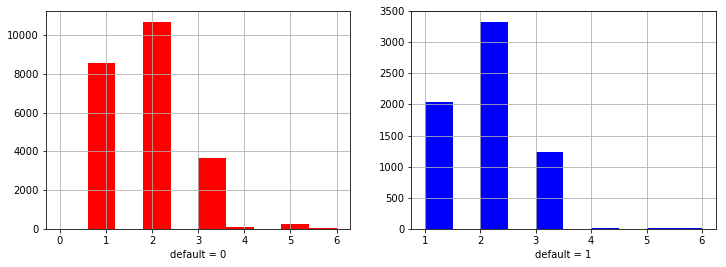

In [32]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(non_default_educ_dist, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(default_educ_dist, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

In [33]:
matrix = pd.DataFrame()

In [34]:
matrix['PhD'] = [len(non_default_educ_dist[non_default_educ_dist == 0]),
                 len(default_educ_dist[default_educ_dist == 0])]

matrix['master'] = [len(non_default_educ_dist[non_default_educ_dist == 1]),
                 len(default_educ_dist[default_educ_dist == 1])]

matrix['bachelor'] = [len(non_default_educ_dist[non_default_educ_dist == 2]),
                 len(default_educ_dist[default_educ_dist == 2])]

matrix['grad_school'] = [len(non_default_educ_dist[non_default_educ_dist == 3]),
                 len(default_educ_dist[default_educ_dist == 3])]

matrix['school'] = [len(non_default_educ_dist[non_default_educ_dist == 4]),
                 len(default_educ_dist[default_educ_dist == 4])]

matrix['other'] = [len(non_default_educ_dist[non_default_educ_dist == 5]),
                 len(default_educ_dist[default_educ_dist == 5])]

matrix['none'] = [len(non_default_educ_dist[non_default_educ_dist == 6]),
                 len(default_educ_dist[default_educ_dist == 6])]

In [35]:
chi2, p, dof, expected = stats.chi2_contingency(matrix)

In [36]:
print p

1.23326262454e-32


Гипотеза о независимости отвергается

In [37]:
expec = matrix

In [38]:
expec = expec - expec + expected

In [142]:
expec

,PhD,master,bachelor,grad_school,school,other,none
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


In [39]:
matrix

,PhD,master,bachelor,grad_school,school,other,none
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


### Таблица сопряженности "образование" на "возврат долга", где значение ячейки есть разность между наблюдаемым и ожидаемым количеством человек

In [40]:
(matrix - expec)

,PhD,master,bachelor,grad_school,school,other,none
0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Чтобы привести к одному масштабу, я бы предложил считать отношение разности к общему числу людей с определенной степенью образования, то есть какой процент людей оказался в другой группе по сравнению с ожидаемым распределением:

In [41]:
(matrix - expec)/sum(matrix, axis = 0)*100

,PhD,master,bachelor,grad_school,school,other,none
0,22.12,2.885234,-1.614854,-3.037616,16.428943,15.691429,6.433725
1,-22.12,-2.885234,1.614854,3.037616,-16.428943,-15.691429,-6.433725


Вывод:таким образом, если опираться на нормированные данные, наличие PhD является индикатором того, что человек отдаст долг, а степень выпускника школы - того, что не отдаст. Но для PhD выборка слишком маленькая, поэтому лучше сказать, что наличие неоконченного школьного или другого образования - хорошие индикаторы возврата кредита.

## Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [42]:
non_default_mar = data[data.default == 0].MARRIAGE.values
default_mar = data[data.default == 1].MARRIAGE.values

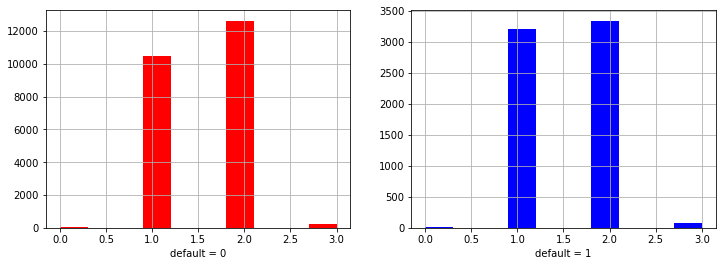

In [43]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(non_default_mar, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(default_mar, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

Признаки категориальные потому, следует применять критерий V Крамера. Для этого посчитаем сначала статистику хи-квадрат.

H0: признаки MARRIAGE и default независимы

H1: H0 неверна

In [44]:
matrix = pd.DataFrame()

In [46]:
matrix['no_answer'] = [len(non_default_mar[non_default_mar == 0]),
                 len(default_mar[default_mar == 0])]

matrix['married'] = [len(non_default_mar[non_default_mar == 1]),
                 len(default_mar[default_mar == 1])]

matrix['unmarried'] = [len(non_default_mar[non_default_mar == 2]),
                 len(default_mar[default_mar == 2])]

matrix['no_data'] = [len(non_default_mar[non_default_mar == 3]),
                 len(default_mar[default_mar == 3])]


In [47]:
matrix

,no_answer,married,unmarried,no_data
0,49,10453,12623,239
1,5,3206,3341,84


In [48]:
chi2, p, dof, expected = stats.chi2_contingency(matrix)

In [49]:
print p

8.82586245758e-08


Гипотеза о независимости отвергается

Коэффициент V Крамера:

In [51]:
V_Cramer = np.sqrt(chi2/(sum(sum(matrix))*2))

In [52]:
print V_Cramer

0.0243797716131


## Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [53]:
non_default_age = data[data.default == 0].AGE.values
default_age = data[data.default == 1].AGE.values

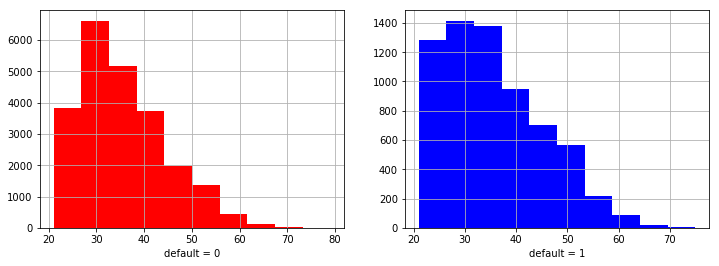

In [56]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(non_default_age, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(default_age, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

### Точечная оценка разности медиан

In [60]:
np.median(non_default_age) - np.median(default_age)

0.0

### Интервальная оценка разности медиан

In [61]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(non_default_age, default_age))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-26.  27.]


Доверительный интервал практически симметричен относительно нуля, так что можно считать, что медианы действительно равны.

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [62]:
print "p-value: %f" % permutation_test(non_default_age, default_age, max_permutations = 5000)

p-value: 0.018000


Гипотеза о равенстве распределений отвергается